In [2]:
#! pip install causalgraphicalmodels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

# Adjustment set with 1 variable

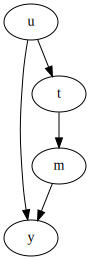

In [4]:
fd0 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.3,0.7), (1,): (0.9,0.1)}),       
    # (0,): (0.5,0.5) means the following
    # given the value of input "0" (in this case we have only 1 input variable "u"), 
    # the resulting descrete values are generated with certain probability: 
    # 0 with probability 0.5 and 1 with probability 0.5
    "m": discrete_model(["t"], {(0,): (0.9, 0.1), (1,): (0.2, 0.8)}),
    "y": discrete_model(["m", "u"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.4, 0.6),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.7, 0.3),
    }),
    # (0, 0): (0.95, 0.05), means the following
    # given the value of input "0, 0" (in this case we have 2 input variables  "z" and "u"), 
    # the resulting descrete values are generated with certain probability: 
    # 0 with probability 0.95 and 1 with probability 0.05
})

fd0.cgm.draw()

In [5]:
fd0.cgm.get_all_frontdoor_adjustment_sets('t', 'y')

frozenset({frozenset({'m'})})

Estimate the true causal effect with a simulation of an experiment.

- Use 500000 instances of each value of treatment for estimation
- Perform estimation 10 times and round the result

Your solution

In [23]:
def estimate_conditional_expectation(df, t, y):
    ate=df[df["t"] == 1]["y"].mean() - df[df["t"] == 0]["y"].mean()
    return ate
def ab_test(scm, t, y, n=1000000):
    scm_do = scm.do(t)
    n_a = int(n / 2)
    n_b = n - n_a
    set_variable = np.array([0]*n_a + [1]*n_b)
    samp = (
        scm_do
        .sample(
            set_values={t: set_variable}, 
            n_samples=n)
    )
    return estimate_conditional_expectation(samp, t, y)

In [31]:
print("Estimated ATE: {:.5f}".format(ab_test(fd0, "t", "y")))

Estimated ATE: -0.38316


In [38]:
#10 times 
result=[]
for i in range (0,10):
    result.append(ab_test(fd0, "t", "y"))
    ATE = np.mean(result)
print(f"Average of 10 times ATE : {ATE}")

Average of 10 times ATE : -0.3848932


Estimate ATE using frontdoor adjustment:

$ATE = E[Y|do(t=1)] - E[Y|do(t=0)]$

$E[Y|do(t)] = \sum_m P(m| t) \sum_{t'} E[Y|m, t'] P(t')$

Sample 1000000 observations from the model for calculations.

Compare your estimation with the true causal effect.

$E[Y|do(t=1)] = \sum_m P(m| t=1) \sum_{t'} E[Y|m, t'] P(t')$

$E[Y|do(t=1)] = \sum_m P(m| t=1) ( E[Y|m, t'=0] P(t'=0) + E[Y|m, t'=1] P(t'=1))$



$E[Y|do(t=1)] =  P(m=0| t=1) \left[ E[Y|m=0, t'=0] P(t'=0) + E[Y|m=0, t'=1] P(t'=1)\right] +P(m=1| t=1) \left[ E[Y|m=1, t'=0] P(t'=0) + E[Y|m=1, t'=1] P(t'=1)\right]$



Answers for intermediate steps

`Probabilities of t: [0.600145, 0.39985499999999996]`

`Probabilities of m|t=0: [0.8997425622141316, 0.10025743778586838]`

`Probabilities of m|t=1: [0.20083030098410673, 0.7991696990158933]`

`E_y_0_0 = 0.674442938204661`

`E_y_0_1 = 0.8632180615917213`

`E_y_1_0 = 0.2503282421180342`

`E_y_1_1 = 0.12590011323752978`

`E[Y|do(t=1) = 0.31053464249294344`

`E[Y|do(t=0) = 0.694803138475164`

`ate = -0.3842684959822205`

`Error: 0.276%`

In [60]:
def probability(df,v1,v2,v3):
    result = (len(df[(df["m"] == v1) & (df["t"] == v2)]) /len(df[df["t"] == v2])) *  (df[(df["m"] == v1) & (df["t"] == v3)]["y"].mean()) * (len(df[df["t"] == v3])/len(df))
    return result

In [78]:
df = fd0.sample(n_samples=1000000)
df.head()

,u,t,m,y
0,0,1.0,1.0,0.0
1,1,0.0,0.0,1.0
2,0,1.0,1.0,0.0
3,1,0.0,0.0,0.0
4,1,0.0,0.0,1.0


Your solution

In [86]:
p1=probability(df,0,1,0) # P(m=0|t=1)[E[Y|m=0,t′=0]P(t′=0)]
p2=probability(df,0,1,1) # P(m=0|t=1)[E[Y|m=0,t′=1]P(t′=1)]
p3=probability(df,1,1,0) # P(m=1|t=1)[E[Y|m=1,t′=0]P(t′=0)]
p4=probability(df,1,1,1)  #P(m=1|t=1)[E[Y|m=1,t′=1]P(t′=1)]
print(f"P(m=0|t=1)[E[Y|m=0,t′=0]P(t′=0)] : {p1}")
print(f"P(m=0|t=1)[E[Y|m=0,t′=1]P(t′=1)] : {p2}")
print(f"P(m=1|t=1)[E[Y|m=1,t′=0]P(t′=0)] : {p3}")
print(f"P(m=1|t=1)[E[Y|m=1,t′=1]P(t′=1)] : {p4}")
res1=p1+p2+p3+p4
print(f"E[Y|do(t=1)]  :  {res1}")

P(m=0|t=1)[E[Y|m=0,t′=0]P(t′=0)] : 0.08112383219824168
P(m=0|t=1)[E[Y|m=0,t′=1]P(t′=1)] : 0.06923000000000001
P(m=1|t=1)[E[Y|m=1,t′=0]P(t′=0)] : 0.11977397828473985
P(m=1|t=1)[E[Y|m=1,t′=1]P(t′=1)] : 0.039951
E[Y|do(t=1)]  :  0.3100788104829815


In [85]:
p5=probability(df,0,0,0)
p6=probability(df,0,0,1)
p7=probability(df,1,0,0)
p8=probability(df,1,0,1)
print(f"P(m=0|t=0)[E[Y|m=0,t′=0]P(t′=0)] : {p5}")
print(f"P(m=0|t=0)[E[Y|m=0,t′=1]P(t′=1)] : {p6}")
print(f"P(m=1|t=0)[E[Y|m=1,t′=0]P(t′=0)] : {p7}")
print(f"P(m=1|t=0)[E[Y|m=1,t′=1]P(t′=1)] : {p8}")
res0=p5+p6+p7+p8
print(f"E[Y|do(t=0)]  :  {res0}")
ate=res1-res0
print(f"ATE= : {ate}")

P(m=0|t=0)[E[Y|m=0,t′=0]P(t′=0)] : 0.364172
P(m=0|t=0)[E[Y|m=0,t′=1]P(t′=1)] : 0.31077954377685885
P(m=1|t=0)[E[Y|m=1,t′=0]P(t′=0)] : 0.014985
P(m=1|t=0)[E[Y|m=1,t′=1]P(t′=1)] : 0.0049982954859926765
E[Y|do(t=0)]  :  0.6949348392628516
ATE= : -0.3848560287798701


# Adjustment set with 2 variables

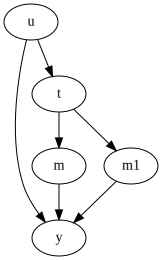

In [89]:
fd2 = StructuralCausalModel({
    "u": lambda n_samples: np.random.binomial(n=1, p=0.3, size=n_samples),
    "t": discrete_model(["u"], {(0,): (0.1,0.9), (1,): (0.8,0.2)}),
    "m": discrete_model(["t"], {(0,): (0.7, 0.3), (1,): (0.1, 0.9)}),
    "m1": discrete_model(["t"], {(0,): (0.6, 0.4), (1,): (0.45, 0.55)}),
    "y": discrete_model(["m", "m1", "u"], {
        (0, 0, 0): (0.2, 0.8), 
        (0, 0, 1): (0.1, 0.9),
        (0, 1, 0): (0.6, 0.4), 
        (0, 1, 1): (0.4, 0.6),
        (1, 0, 0): (0.7, 0.3), 
        (1, 0, 1): (0.8, 0.2),
        (1, 1, 0): (0.8, 0.2), 
        (1, 1, 1): (0.7, 0.3),
    }),
})

fd2.cgm.draw()

Do the same for the model with the adjustment set containing 2 variables.

Hint, you can consider the case with 1 variable in the adjustment set, but the new variable now has 4 possible values: 
(0,0), (0,1), (1,0), (1,1).

Your solution

In [95]:
df1 = fd2.sample(n_samples=100000)
def probability2(df,v1,v2,v3,v4):
    result = (len(df[(df["m"] == v1) & (df["m1"] == v2) & (df["t"] == v3)]) /len(df[df["t"] == v3])) *  (df[(df["m"] == v1) & (df["m1"] == v2) &(df["t"] == v4)]["y"].mean()) * (len(df[df["t"] == v4])/len(df))
    return result

In [96]:
p_1=probability2(df1,0,0,1,0) 
p_2=probability2(df1,1,0,1,0) 
p_3=probability2(df1,0,1,1,0) 
p_4=probability2(df1,1,1,1,0)  
p_5=probability2(df1,0,0,1,1) 
p_6=probability2(df1,1,0,1,1) 
p_7=probability2(df1,0,1,1,1) 
p_8=probability2(df1,1,1,1,1)  
print(f"P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=0]P(t′=0)] : {p_1}")
print(f"P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=0]P(t′=0)] : {p_2}")
print(f"P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=0]P(t′=0)] : {p_3}")
print(f"P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=0]P(t′=0)] : {p_4}")
print(f"P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=0]P(t′=1)] : {p_5}")
print(f"P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=0]P(t′=1)] : {p_6}")
print(f"P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=0]P(t′=1)] : {p_7}")
print(f"P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=0]P(t′=1)] : {p_8}")
res_2_1=p_1+p_2+p_3+p_4+p_5+p_6+p_7+p_8
print(f"E[Y|do(t=1)]  :  {res_2_1}")

P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=0]P(t′=0)] : 0.012031363452384244
P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=0]P(t′=0)] : 0.028614009336330886
P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=0]P(t′=0)] : 0.009196471625159347
P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=0]P(t′=0)] : 0.0427489475925341
P(m=0,m1=0|t=1)[E[Y|m=0,m1=0,t′=0]P(t′=1)] : 0.024659999999999998
P(m=1,m1=0|t=1)[E[Y|m=1,m1=0,t′=0]P(t′=1)] : 0.08162
P(m=0,m1=1|t=1)[E[Y|m=0,m1=1,t′=0]P(t′=1)] : 0.015780000000000002
P(m=1,m1=1|t=1)[E[Y|m=1,m1=1,t′=0]P(t′=1)] : 0.07217
E[Y|do(t=1)]  :  0.2868207920064086


In [99]:
p_9=probability2(df1,0,0,0,0) 
p_10=probability2(df1,1,0,0,0) 
p_11=probability2(df1,0,1,0,0) 
p_12=probability2(df1,1,1,0,0)  
p_13=probability2(df1,0,0,0,1) 
p_14=probability2(df1,1,0,0,1) 
p_15=probability2(df1,0,1,0,1) 
p_16=probability2(df1,1,1,0,1)  
print(f"P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=0]P(t′=0)] : {p_9}")
print(f"P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=0]P(t′=0)] : {p_10}")
print(f"P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=0]P(t′=0)] : {p_11}")
print(f"P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=0]P(t′=0)] : {p_12}")
print(f"P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=0]P(t′=1)] : {p_13}")
print(f"P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=0]P(t′=1)] : {p_14}")
print(f"P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=0]P(t′=1)] : {p_15}")
print(f"P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=0]P(t′=1)] : {p_16}")
res_2_0=p_9+p_10+p_11+p_12+p_13+p_14+p_15+p_16
print(f"E[Y|do(t=0)]  :  {res_2_0}")
ate2var=res_2_1-res_2_0
print(f"ATE= : {ate2var}")

P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=0]P(t′=0)] : 0.11319
P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=0]P(t′=0)] : 0.012689999999999998
P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=0]P(t′=0)] : 0.04802
P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=0]P(t′=0)] : 0.010529999999999998
P(m=0,m1=0|t=0)[E[Y|m=0,m1=0,t′=0]P(t′=1)] : 0.2319990922929734
P(m=1,m1=0|t=0)[E[Y|m=1,m1=0,t′=0]P(t′=1)] : 0.03619757678225504
P(m=0,m1=1|t=0)[E[Y|m=0,m1=1,t′=0]P(t′=1)] : 0.08239633969260143
P(m=1,m1=1|t=0)[E[Y|m=1,m1=1,t′=0]P(t′=1)] : 0.01777704815668308
E[Y|do(t=0)]  :  0.5528000569245131
ATE= : -0.2659792649181045


# Assignment

1. Implement a function for calculating ATE using front-door adjustment for an arbitrary number of adjusting variables. You can assume that all variables are binary. 

2. Compare your results with back-door adjustment. Note, that we assumed variable 𝑈 to be unobserved, however it is not.

3. Demostrate your code for 1, 2 and 3 (or more) adjusting variables.

In [117]:
def estiamte_ate_frontdoor_dis(df,t,y,zs):
    df['concat'] = ""
    for e in zs:
      df['concat'] = df['concat'] + df[e].apply(str)
    combs = df['concat'].unique()
    val = []
    for comb in combs:
        prob_C = len(df[df['concat'] == comb]) / len(df)
        zs_unique = [tuple(a) for a in np.unique(df[zs].values, axis=0)]
        y_unique = np.unique(df[y].values, axis=0)    
        
        # P(X)
        p_x = {
            x_: np.mean(df[t] == x_)
            for x_ in (0,1)
        }
        
        # P(Z|X)
        p_z_x = {
            (x_, z_): np.mean(df
                .loc[lambda df_: df_[t] == x_]
                [zs]
                .values == z_)
            for x_ in (0,1)
            for z_ in zs_unique
        }
        
        # P(Y|X,Z)
        p_y_xz = {
            (x_, y_, z_): np.mean(df
                .loc[lambda df_: df_[t] == x_]
                .loc[lambda df_: (df_[zs] == z_).squeeze()]
                [y]
                .values == y_)
            for x_ in (0,1)
            for y_ in y_unique
            for z_ in zs_unique
        }
        
        # ATE
        E_y_do_x_0 = 0.0
        E_y_do_x_1 = 0.0
        for y_ in y_unique:
            for zs_ in  zs_unique:
                for x_ in [0,1]:
                    E_y_do_x_0 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(0, zs_)] * p_x[x_]
                    E_y_do_x_1 += y_ * p_y_xz[(x_, y_, zs_)] * p_z_x[(1, zs_)] * p_x[x_]
        val.append(prob_C * (E_y_do_x_1 - E_y_do_x_0))
    ate=sum(val)
        
    return ate

In [118]:
df1 = fd0.sample(n_samples=100000)
estiamte_ate_frontdoor_dis(df1, "t", "y", ["m"])

-0.3834634662676836